# Imports

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os
import io
import datetime
import string
import re
from numpy import random
import gensim.downloader as api
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Dense,Flatten,SimpleRNN,InputLayer,Conv1D,Bidirectional,GRU,LSTM,BatchNormalization,Dropout,Input, Embedding,TextVectorization)
from tensorflow.keras import layers
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
from google.colab import files
from tensorflow.keras.callbacks import Callback
from tensorboard.plugins import projector
from datetime import datetime as dt
from tensorflow.keras.callbacks import TensorBoard
from keras.utils import to_categorical
from sklearn.metrics import classification_report

In [2]:
! wget https://raw.githubusercontent.com/DriveMyScream/Python_libraries/main/helper_functions.py

--2023-09-22 18:27:04--  https://raw.githubusercontent.com/DriveMyScream/Python_libraries/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7752 (7.6K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   7.57K  --.-KB/s    in 0s      

2023-09-22 18:27:04 (85.2 MB/s) - ‘helper_functions.py’ saved [7752/7752]



In [3]:
from helper_functions import (make_confusion_matrix, plot_loss_curves, calculate_results, plot_class_accuracy,
                              plot_prediction_confidence_histogram, create_tensorboard_callback)

# Data Downloading

In [4]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json
! kaggle datasets download -d therohk/million-headlines
! unzip "/content/million-headlines.zip" -d "/content/dataset/"

 23% 5.00M/21.4M [00:00<00:00, 39.5MB/s]
100% 21.4M/21.4M [00:00<00:00, 104MB/s] 
Archive:  /content/million-headlines.zip
  inflating: /content/dataset/abcnews-date-text.csv  


# Data Loading

In [5]:
df = pd.read_csv("/content/dataset/abcnews-date-text.csv")

In [6]:
df.head(5)

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit
3,20030219,air nz staff in aust strike for pay rise
4,20030219,air nz strike to affect australian travellers


In [7]:
df = df.drop(['publish_date'], axis=1)
df = df.rename(columns = {'headline_text': 'text'})
df['text'] = df['text'].astype(str)

# Data Labaling

In [ ]:
pip install snorkel

In [ ]:
from snorkel.labeling import LabelingFunction

In [ ]:
from snorkel.preprocess import preprocessor
from textblob import TextBlob
from snorkel.labeling import PandasLFApplier
from snorkel.labeling.model import LabelModel
from snorkel.labeling import LFAnalysis
from snorkel.labeling import filter_unlabeled_dataframe
from snorkel.labeling import labeling_function

In [ ]:
POSITIVE = 1
NEGATIVE = 0
ABSTAIN = -1

def keyword_lookup(x, keywords, label):
    if any(word in x.text.lower() for word in keywords):
        return label
    return ABSTAIN

def make_keyword_lf(keywords, label=POSITIVE):
    return LabelingFunction(
        name=f"keyword_{keywords[0]}",
        f=keyword_lookup,
        resources=dict(keywords=keywords, label=label))


keyword_positive = make_keyword_lf(keywords=['boosts', 'great', 'develops', 'promising', 'ambitious', 'delighted', 'record', 'win',
                                             'breakthrough', 'recover', 'achievement', 'peace', 'party', 'hope', 'flourish', 'respect', 'partnership',
                                             'champion', 'positive', 'happy', 'bright', 'confident', 'encouraged', 'perfect', 'complete', 'assured'], label=POSITIVE)

keyword_negative = make_keyword_lf(keywords=['war','solidiers', 'turmoil', 'injur','trouble', 'aggressive',
                                             'killed', 'coup', 'evasion', 'strike', 'troops', 'dismisses', 'attacks', 'defeat', 'damage', 'dishonest',
                                             'dead', 'fear', 'foul', 'fails', 'hostile', 'cuts', 'accusations', 'victims',  'death', 'unrest', 'fraud',
                                             'dispute', 'destruction', 'battle', 'unhappy', 'bad', 'alarming', 'angry', 'anxious', 'dirty', 'pain', 'poison',
                                             'unfair', 'unhealthy'], label=NEGATIVE)

In [ ]:
#set up a preprocessor function to determine polarity & subjectivity using textlob pretrained classifier
@preprocessor(memoize=True)
def textblob_sentiment(x):
    scores = TextBlob(x.text)
    x.polarity = scores.sentiment.polarity
    x.subjectivity = scores.sentiment.subjectivity
    return x

#find polarity
@labeling_function(pre=[textblob_sentiment])
def textblob_polarity(x):
    return POSITIVE if x.polarity > 0.6 else ABSTAIN


#find subjectivity
@labeling_function(pre=[textblob_sentiment])
def textblob_subjectivity(x):
    return POSITIVE if x.subjectivity >= 0.5 else ABSTAIN

In [ ]:
#combine all the labeling functions
lfs = [keyword_positive, keyword_negative, textblob_polarity, textblob_subjectivity]
#apply the lfs on the dataframe
applier = PandasLFApplier(lfs=lfs)
L_snorkel = applier.apply(df=df)
#apply the label model
label_model = LabelModel(cardinality=2, verbose=True)
#fit on the data
label_model.fit(L_snorkel)
#predict and create the labels
df["label"] = label_model.predict(L=L_snorkel)

100%|██████████| 100/100 [00:00<00:00, 377.17epoch/s]


In [ ]:
#Filtering out unlabeled data points
df= df.loc[df.label.isin([0,1]), :]
#find the label counts
df['label'].value_counts()

1    238018
0    109987
Name: label, dtype: int64

In [ ]:
df.to_csv("News_Sentiment_Analysis.csv", index=False)

In [ ]:
%cp -av /content/News_Sentiment_Analysis.csv /content/drive/MyDrive/

'/content/News_Sentiment_Analysis.csv' -> '/content/drive/MyDrive/News_Sentiment_Analysis.csv'


# Data loading

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
df = pd.read_csv("/content/drive/MyDrive/News_Sentiment_Analysis.csv")

In [15]:
df.head(5)

,text,label
0,act fire witnesses must be aware of defamation,0
1,air nz staff in aust strike for pay rise,0
2,air nz strike to affect australian travellers,0
3,ambitious olsson wins triple jump,1
4,antic delighted with record breaking barca,1


In [16]:
df.isnull().sum()

text     0
label    0
dtype: int64

In [17]:
df.duplicated().sum()

3189

In [18]:
df.drop_duplicates(inplace=True)

In [19]:
df['label'].value_counts()

1    235895
0    108921
Name: label, dtype: int64

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 344816 entries, 0 to 348004
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    344816 non-null  object
 1   label   344816 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 7.9+ MB


In [21]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub('https?://\S+|www\.\S+', ' ', text) # Remove URL from string
    text = re.sub('<.*?>+', ' ', text) # Remove HTML Tags
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text) # Replace Punctuation with space
    text = re.sub('\n', ' ', text) # Replace NewLine with space
    text = re.sub(r'\w*\d\w*', ' ', text) # Remove alphanumeric
    text = text.replace('-', ' ')
    text = text.replace('’’', '').replace('’', '').replace('‘‘', '').replace('‘', '')
    text = ' '.join(text.split())  # Strip extra spaces
    return text

In [22]:
clean_text("<u>In the movie?, </u>man called Tévèz, went to a friend’s pl**ce and they had a tensed discussion. I don’t love this ** ?????? ?movie! would you?<br> <br /><br />T")

'in the movie man called tévèz went to a friends pl ce and they had a tensed discussion i dont love this movie would you t'

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.20)

In [25]:
train_sentences = X_train.apply(clean_text)
test_sentences = X_test.apply(clean_text)
train_sentences = train_sentences.tolist()
test_sentences = test_sentences.tolist()

In [26]:
class_labels = ['NEGATIVE', 'POSITIVE']
print("Classes:", class_labels)

Classes: ['NEGATIVE', 'POSITIVE']


In [27]:
print("Total train sentences")
len(train_sentences), len(y_train)

Total train sentences


(275852, 275852)

In [28]:
print("Total test sentences")
len(test_sentences), len(y_test)

Total test sentences


(68964, 68964)

# Base Line Model

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

baseline_model = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

baseline_model.fit(X = train_sentences,
                   y = y_train)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [30]:
baseline_model.score(X = test_sentences,
                     y = y_test)

0.8872745200394409

In [31]:
baseline_preds = baseline_model.predict(test_sentences)

In [32]:
baseline_results = calculate_results(y_true = y_test,
                                     y_pred = baseline_preds)

In [33]:
baseline_results

{'accuracy': 88.72745200394408,
 'precision': 0.8979324977867675,
 'recall': 0.8872745200394409,
 'f1': 0.8805038683011687}

# Average Sequence Length

In [34]:
sentences_length = [len(sentence.split()) for sentence in df['text']]
avg_sentence_length = np.mean(sentences_length)
print(avg_sentence_length)

6.965387337014524


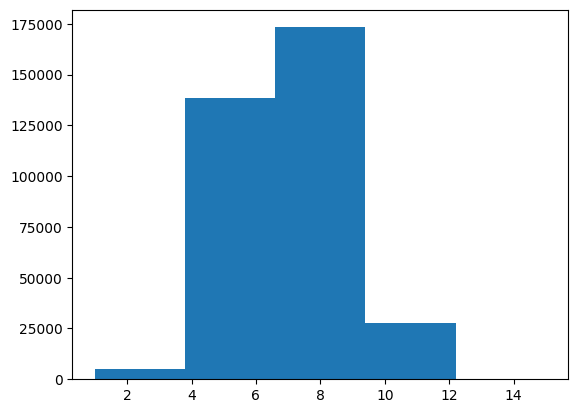

In [35]:
plt.hist(sentences_length, bins=5);

In [36]:
output_sequence_length = int(np.percentile(sentences_length, 95))
print(output_sequence_length)

10


In [37]:
max_tokens = 20000
vectorize_layer = TextVectorization(max_tokens = max_tokens,
                                    output_mode = 'int',
                                    standardize = None,
                                    output_sequence_length = 10)

vectorize_layer.adapt(df['text'])

In [38]:
random_sentence = random.choice(train_sentences)
print('Sentence:', random_sentence)
print('Length of sentence:', len(random_sentence.split()))
print('Vectorized_Form:', vectorize_layer([random_sentence]))

Sentence: new zealand travellers fly to victoria and wa
Length of sentence: 8
Vectorized_Form: tf.Tensor([[  27  944 3191  268    2  222   19   55    0    0]], shape=(1, 10), dtype=int64)


In [39]:
text_vocab = vectorize_layer.get_vocabulary()
print("Total number of words in vocalbuary", len(text_vocab))
print("The Top Most 5 common words in vocalbuary:", text_vocab[:5])
print("The Least Most 5 common words in vocalbuary:", text_vocab[-5:])

Total number of words in vocalbuary 20000
The Top Most 5 common words in vocalbuary: ['', '[UNK]', 'to', 'in', 'for']
The Least Most 5 common words in vocalbuary: ['underfunded', 'underestimated', 'unconvincing', 'uncles', 'unclaimed']


In [40]:
vectorize_layer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None, None),
 'max_tokens': 20000,
 'standardize': None,
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 10,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 20000}

In [41]:
token_embed = Embedding(input_dim = 20000,
                        output_dim = 128,
                        name = "Embeddings")

In [42]:
target_sentence = random.choice(train_sentences)
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = vectorize_layer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
nine killed as train hits school truck in thailand

Sentence after vectorization (before embedding):
[[ 921   18   20  332  241  108  459    3 1450    0]]

Sentence after embedding:
[[[-0.01680397  0.02250281 -0.02338829 ... -0.00478552 -0.01265478
   -0.04061176]
  [ 0.00210351  0.03626797 -0.04009795 ... -0.01525404 -0.04168101
   -0.02709849]
  [ 0.00147848 -0.02244117 -0.01438179 ...  0.00796226  0.043995
   -0.00872091]
  ...
  [ 0.00274865  0.04252649 -0.01644809 ... -0.00667356 -0.04228463
   -0.03594408]
  [-0.01144215 -0.01859788  0.04983611 ...  0.01147797 -0.0196069
    0.0258456 ]
  [ 0.00536438 -0.04424739 -0.02088367 ...  0.00760583  0.03047616
   -0.03793259]]]

Embedded sentence shape: (1, 10, 128)


# Finding Best Embeddings for dataset

In [ ]:
!pip install -q git+https://github.com/tensorflow/docs
import pathlib
import shutil
import tempfile
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
# Define a path for tensorboard
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [ ]:
def train_and_evaluate_model(module_url, embed_size, name, trainable=True):

  hub_layer = hub.KerasLayer(module_url, input_shape=[], output_shape=[embed_size], dtype=tf.string, trainable=trainable)

  model = tf.keras.models.Sequential([hub_layer,
                                      tf.keras.layers.Dense(256, activation='relu'),
                                      tf.keras.layers.Dense(64, activation='relu'),
                                      tf.keras.layers.Dense(7, activation='softmax')
  ])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.losses.CategoricalCrossentropy(),
              metrics = ['accuracy'])

  history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=test_dataset,
                    callbacks=[tfdocs.modeling.EpochDots(),
                               tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min'),
                               tf.keras.callbacks.TensorBoard(logdir/name)],
                    verbose=0)
  return history

In [ ]:
histories = {}

In [ ]:
module_url = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1" #@param ["https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", "https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"] {allow-input: true}

In [ ]:
module_url

In [ ]:
histories['nnlm-en-dim50'] = train_and_evaluate_model(module_url, embed_size=50, name='nnlm-en-dim50')

In [ ]:
plt.rcParams['figure.figsize'] = (12, 8)
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy')
plotter.plot(histories)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Accuracy Curves for Models")
plt.show()

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss')
plotter.plot(histories)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Loss Curves for Models")
plt.show()

In [ ]:
%load_ext tensorboard

%tensorboard --logdir {logdir}

# Universal Sentence Encoder

In [43]:
import tensorflow_hub as hub
embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                  trainable=False,
                                  name="universal_sentence_encoder")

In [44]:
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Shape of sentence embedding:\n{use_embedded_sentence[0].shape}")

Random training sentence:
kwinana freeway in perth closed after man hit by truck

Sentence after embedding:
[ 0.00287168  0.05996418  0.01446347 -0.03158585  0.02446488 -0.07750332
  0.0270989  -0.01704831  0.03913287 -0.05415708  0.01168888 -0.01245779
 -0.01841207 -0.04154139  0.05035204  0.05210774  0.02509324  0.04515284
  0.01539731  0.04318277 -0.06056345  0.00325406  0.02065897 -0.03633993
  0.03327224  0.07907949  0.01407377  0.03269443 -0.06155825  0.04367761] (truncated output)...

Shape of sentence embedding:
(512,)


# Data Loading

In [45]:
sentiment_label = df['label'].value_counts().index
values = df['label'].value_counts().values
total_samples = 344816
weights = {}
for label, value in zip(sentiment_label, values):
  weights[label] = total_samples / value

print("Weights:", weights)

Weights: {1: 1.4617350940036882, 0: 3.1657439795815314}


In [46]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, y_test))

In [47]:
train_dataset = train_dataset.batch(64).shuffle(buffer_size=4029).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(64).shuffle(buffer_size=4029).prefetch(buffer_size=tf.data.AUTOTUNE)

In [48]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [49]:
for sentences, labels in train_dataset.take(1):
  for i in range(3):
    print("Sentence = ", sentences[i])
    print("Labels = ", labels[i])

Sentence =  tf.Tensor(b'myasthenia gravis sufferers need more support', shape=(), dtype=string)
Labels =  tf.Tensor(1, shape=(), dtype=int64)
Sentence =  tf.Tensor(b'tudehope qna and twitter enough is enough', shape=(), dtype=string)
Labels =  tf.Tensor(1, shape=(), dtype=int64)
Sentence =  tf.Tensor(b'protest fails to sway beattie on indigenous', shape=(), dtype=string)
Labels =  tf.Tensor(0, shape=(), dtype=int64)


# Tensorboard Callback

In [50]:
# Directory for tensorboard callback
os.mkdir("logs")

In [51]:
def create_tensorboard_callback(model_name):
  log_dir = os.path.join("logs", model_name + "_" + dt.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = TensorBoard(log_dir=log_dir)
  return tensorboard_callback

# Simple RNN Model

In [52]:
from tensorflow.keras.layers import Reshape, Lambda

In [53]:
input_layer = Input(shape=[], dtype=tf.string)
embeddings = embedding_layer(input_layer)
expand_layer = layers.Lambda(lambda embed: tf.expand_dims(embed, axis=1))(embeddings)
x = Bidirectional(SimpleRNN(64, return_sequences=True))(expand_layer)
x = Bidirectional(SimpleRNN(32))(x)
x = Dense(16)(x)
x = Dropout(0.5)(x)
output_layer = Dense(1, activation='sigmoid')(x)

model_1 = Model(inputs=input_layer, outputs=output_layer)
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 lambda (Lambda)             (None, 1, 512)            0         
                                                                 
 bidirectional (Bidirection  (None, 1, 128)            73856     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                10304     
 onal)                                                           
                                                             

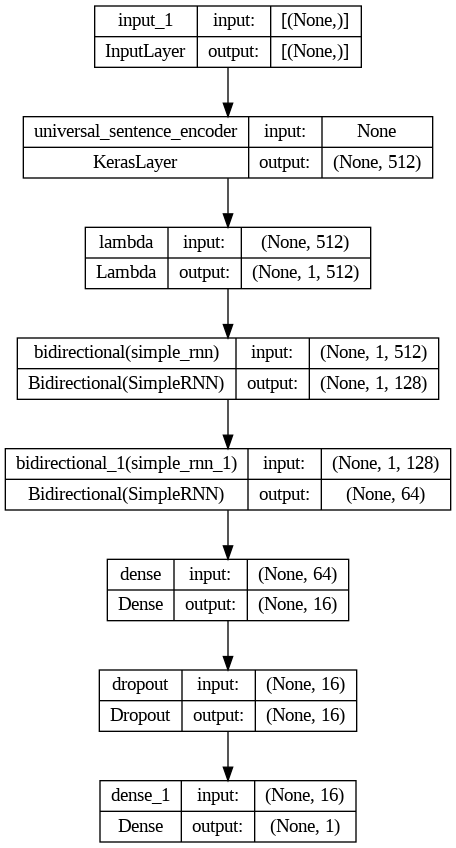

In [54]:
plot_model(model_1, show_shapes=True)

In [55]:
from tensorflow.keras.losses import BinaryCrossentropy

In [56]:
model_1.compile(loss = BinaryCrossentropy(),
                optimizer = Adam(),
                metrics=["accuracy"])

In [57]:
history_1 = model_1.fit(train_dataset,
                        validation_data = test_dataset,
                        callbacks = create_tensorboard_callback("RNN_model"),
                        class_weight = weights,
                        epochs = 5)

Epoch 1/5
4311/4311 [==============================] - 150s 32ms/step - loss: 0.8843 - accuracy: 0.8039 - val_loss: 0.4163 - val_accuracy: 0.8131
Epoch 2/5
4311/4311 [==============================] - 131s 30ms/step - loss: 0.8417 - accuracy: 0.8165 - val_loss: 0.3866 - val_accuracy: 0.8296
Epoch 3/5
4311/4311 [==============================] - 130s 30ms/step - loss: 0.7828 - accuracy: 0.8332 - val_loss: 0.3610 - val_accuracy: 0.8456
Epoch 4/5
4311/4311 [==============================] - 133s 31ms/step - loss: 0.7253 - accuracy: 0.8485 - val_loss: 0.3553 - val_accuracy: 0.8494
Epoch 5/5
4311/4311 [==============================] - 128s 29ms/step - loss: 0.6821 - accuracy: 0.8590 - val_loss: 0.3175 - val_accuracy: 0.8688


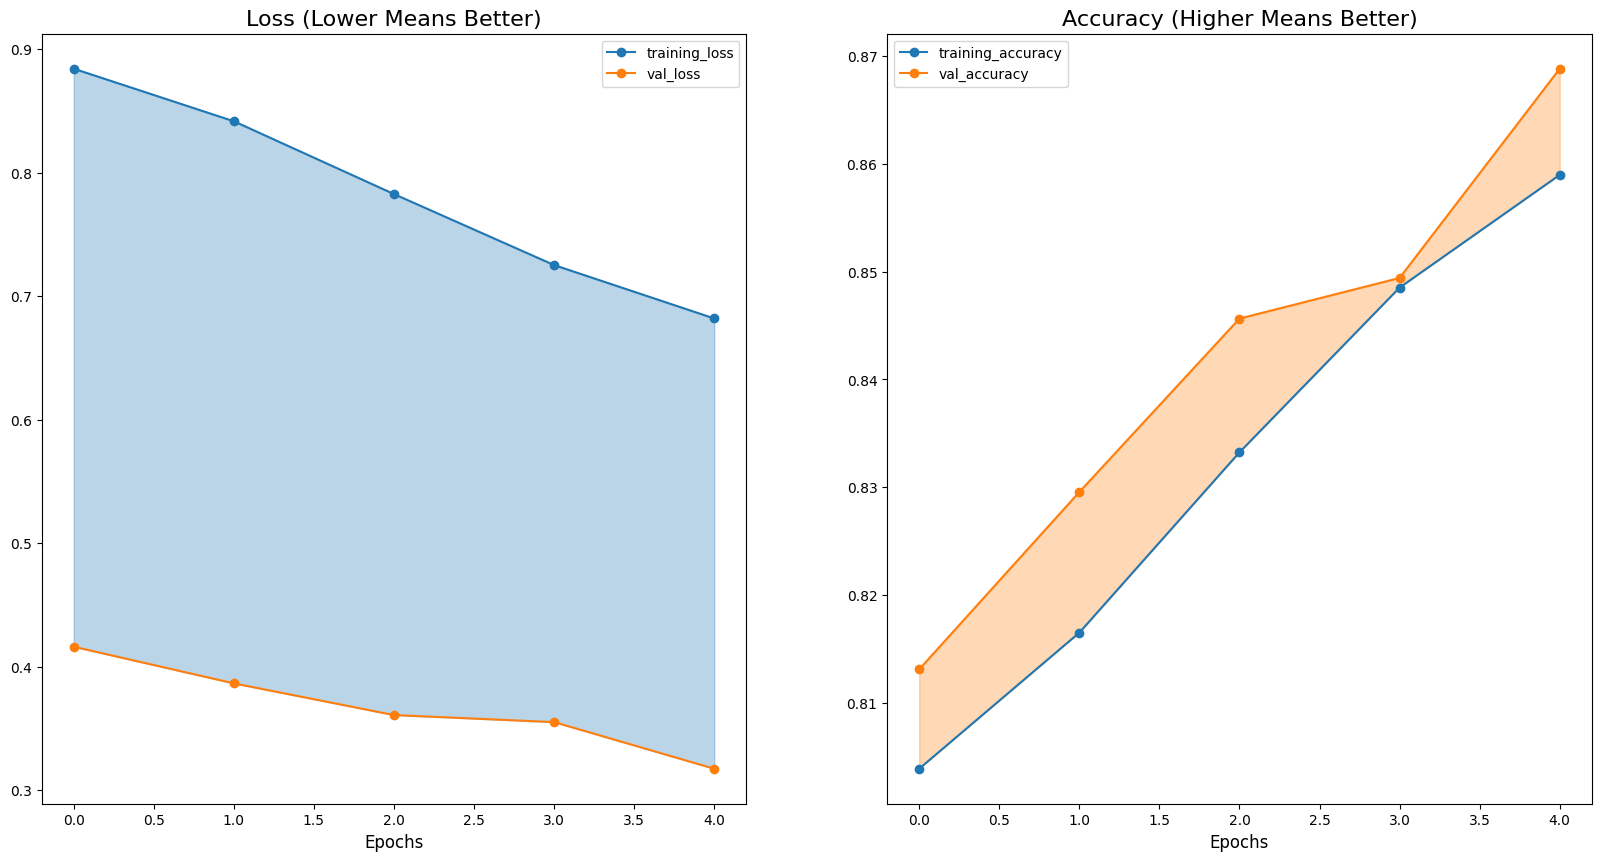

In [58]:
plot_loss_curves(history_1)

In [59]:
model_preds = model_1.predict(test_sentences, verbose=1)
model_preds

2156/2156 [==============================] - 32s 14ms/step


array([[2.2449647e-03],
       [1.1566941e-01],
       [2.9444272e-02],
       ...,
       [7.9611623e-01],
       [7.6654187e-04],
       [9.9716359e-01]], dtype=float32)

In [60]:
model_preds = np.round(model_preds)
model_preds[:5]

array([[0.],
       [0.],
       [0.],
       [1.],
       [0.]], dtype=float32)

In [61]:
true_value = np.array(y_test)
predicted_value = np.array(model_preds)

In [62]:
model_1_results = calculate_results(y_true = true_value,
                                    y_pred = predicted_value)
model_1_results

{'accuracy': 86.88156139435067,
 'precision': 0.873893893761095,
 'recall': 0.8688156139435067,
 'f1': 0.8704084645486313}

Confusion Matrix


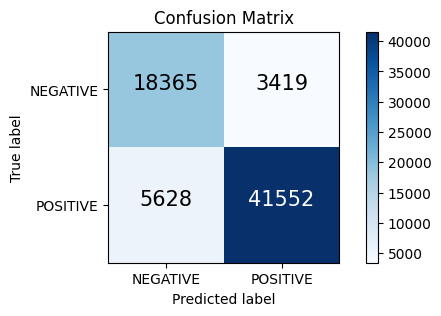

In [63]:
print("Confusion Matrix")
make_confusion_matrix(y_true = true_value,
                      y_pred = predicted_value,
                      classes = class_labels,
                      figsize = (7, 3))

In [64]:
print("Classification Report")
print(classification_report(true_value, predicted_value))

Classification Report
              precision    recall  f1-score   support

           0       0.77      0.84      0.80     21784
           1       0.92      0.88      0.90     47180

    accuracy                           0.87     68964
   macro avg       0.84      0.86      0.85     68964
weighted avg       0.87      0.87      0.87     68964



ClassWise Accuracy


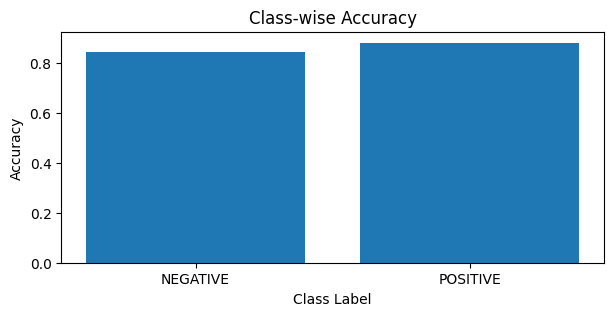

In [65]:
print("ClassWise Accuracy")
plot_class_accuracy(num_classes = 2,
                    y_true = true_value,
                    y_pred = predicted_value,
                    classes = class_labels,
                    figsize = (7, 3))

# LSTM Bidirectional

In [66]:
input_layer = Input(shape=[], dtype=tf.string)
embeddings = embedding_layer(input_layer)
expand_layer = layers.Lambda(lambda embed: tf.expand_dims(embed, axis=1))(embeddings)
x = Bidirectional(LSTM(64, return_sequences=True))(expand_layer)
x = Bidirectional(LSTM(32))(x)
x = Dense(16, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(1, activation='sigmoid')(x)
model_2 = Model(inputs = input_layer,
                outputs = output_layer)

model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 lambda_1 (Lambda)           (None, 1, 512)            0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 1, 128)            295424    
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                           

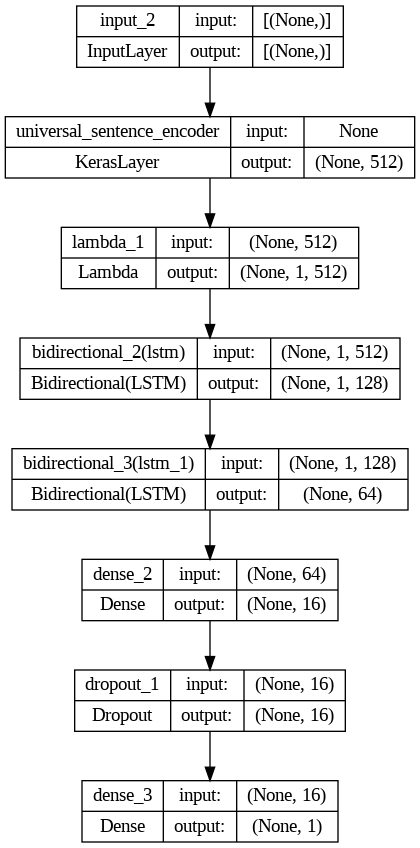

In [67]:
plot_model(model_2, show_shapes=True)

In [68]:
model_2.compile(loss = BinaryCrossentropy(),
                optimizer = Adam(),
                metrics=["accuracy"])

In [69]:
history_2 = model_2.fit(train_dataset,
                        validation_data = test_dataset,
                        class_weight = weights,
                        callbacks = create_tensorboard_callback("LSTM_model"),
                        epochs = 5)

Epoch 1/5
4311/4311 [==============================] - 141s 30ms/step - loss: 0.8181 - accuracy: 0.8253 - val_loss: 0.3398 - val_accuracy: 0.8570
Epoch 2/5
4311/4311 [==============================] - 122s 28ms/step - loss: 0.6543 - accuracy: 0.8687 - val_loss: 0.2893 - val_accuracy: 0.8810
Epoch 3/5
4311/4311 [==============================] - 131s 30ms/step - loss: 0.5834 - accuracy: 0.8829 - val_loss: 0.2976 - val_accuracy: 0.8748
Epoch 4/5
4311/4311 [==============================] - 120s 28ms/step - loss: 0.5392 - accuracy: 0.8916 - val_loss: 0.2514 - val_accuracy: 0.8978
Epoch 5/5
4311/4311 [==============================] - 122s 28ms/step - loss: 0.5013 - accuracy: 0.8978 - val_loss: 0.2637 - val_accuracy: 0.8888


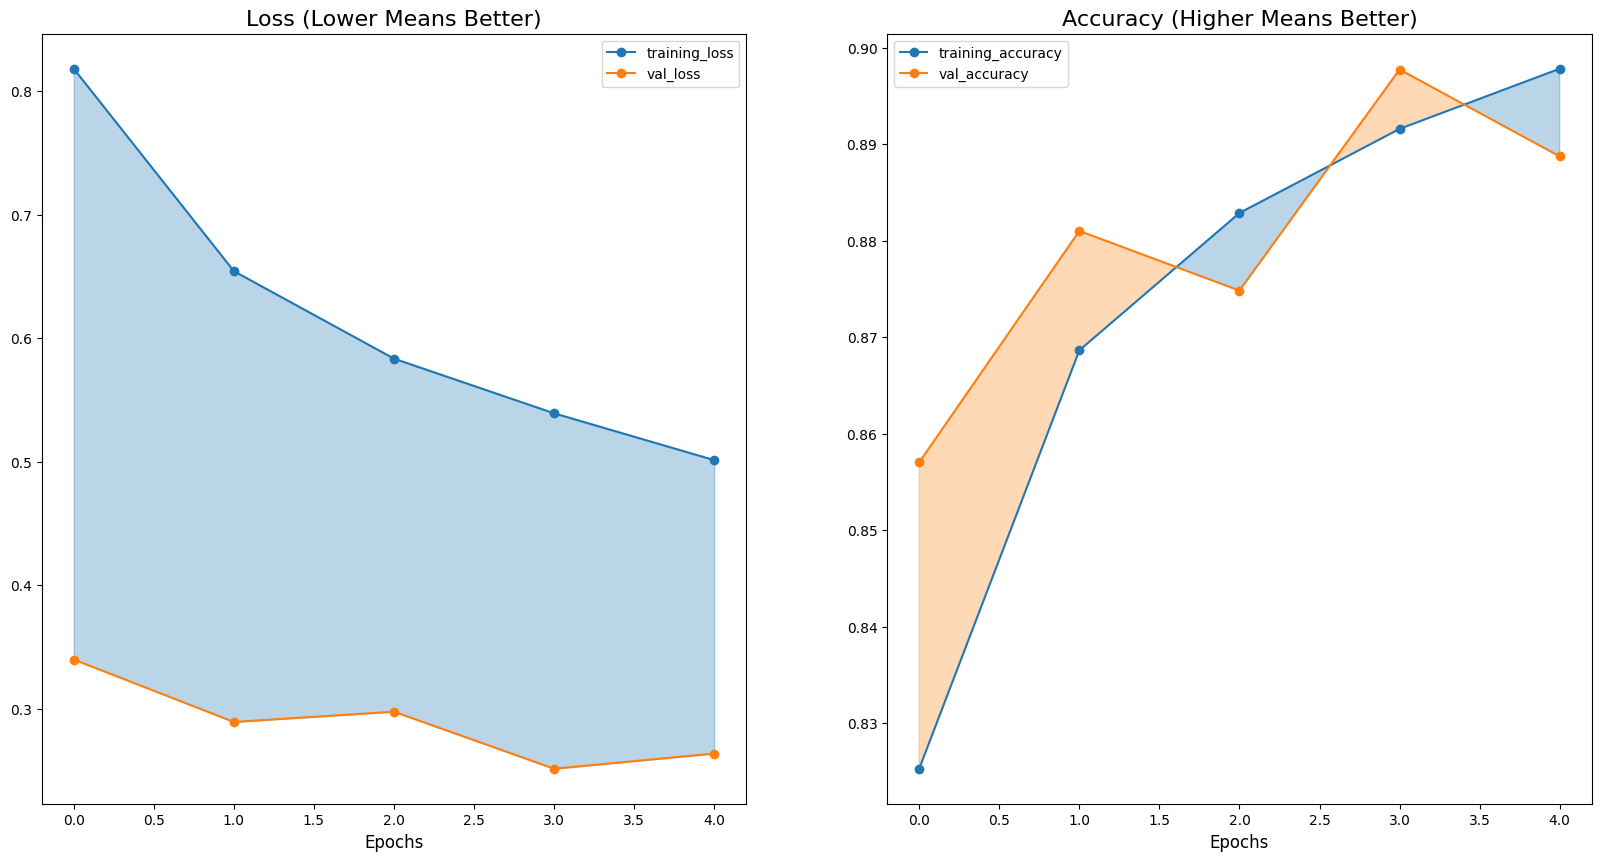

In [70]:
plot_loss_curves(history_2)

In [71]:
model_preds = model_2.predict(test_sentences, verbose=1)
model_preds

2156/2156 [==============================] - 35s 15ms/step


array([[5.1775252e-05],
       [1.6572999e-02],
       [3.7903825e-04],
       ...,
       [5.9627569e-01],
       [5.4250343e-04],
       [9.9999988e-01]], dtype=float32)

In [72]:
model_preds = np.round(model_preds)
model_preds[:5]

array([[0.],
       [0.],
       [0.],
       [1.],
       [0.]], dtype=float32)

In [73]:
true_value = np.array(y_test)
predicted_value = np.array(model_preds)

In [74]:
model_2_results = calculate_results(y_true = true_value,
                                    y_pred = predicted_value)
model_2_results

{'accuracy': 88.87535525781567,
 'precision': 0.8983704756897353,
 'recall': 0.8887535525781567,
 'f1': 0.8908490673105126}

Confusion Matrix


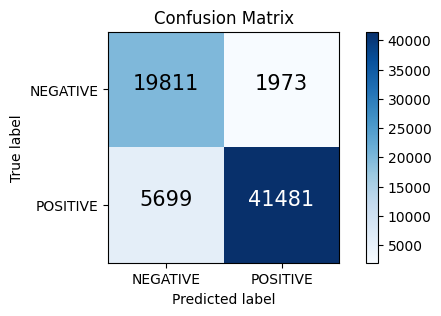

In [75]:
print("Confusion Matrix")
make_confusion_matrix(y_true = true_value,
                      y_pred = predicted_value,
                      classes = class_labels,
                      figsize = (7, 3))

In [76]:
print("Classification Report")
print(classification_report(true_value, predicted_value))

Classification Report
              precision    recall  f1-score   support

           0       0.78      0.91      0.84     21784
           1       0.95      0.88      0.92     47180

    accuracy                           0.89     68964
   macro avg       0.87      0.89      0.88     68964
weighted avg       0.90      0.89      0.89     68964



ClassWise Accuracy


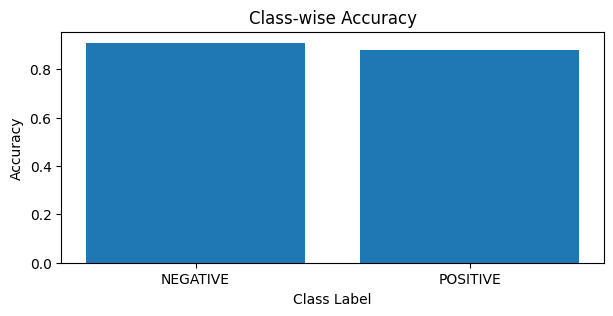

In [77]:
print("ClassWise Accuracy")
plot_class_accuracy(num_classes = 2,
                    y_true = true_value,
                    y_pred = predicted_value,
                    classes = class_labels,
                    figsize = (7, 3))

# GRU Model

In [78]:
input_layer = Input(shape=[], dtype=tf.string)
embeddings = embedding_layer(input_layer)
expand_layer = layers.Lambda(lambda embed: tf.expand_dims(embed, axis=1))(embeddings)
x = Bidirectional(GRU(64, return_sequences=True))(expand_layer)
x = Bidirectional(GRU(32))(x)
x = Dense(16, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(1, activation='sigmoid')(x)
model_3 = tf.keras.Model(inputs = input_layer,
                         outputs = output_layer)

model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 lambda_2 (Lambda)           (None, 1, 512)            0         
                                                                 
 bidirectional_4 (Bidirecti  (None, 1, 128)            221952    
 onal)                                                           
                                                                 
 bidirectional_5 (Bidirecti  (None, 64)                31104     
 onal)                                                           
                                                           

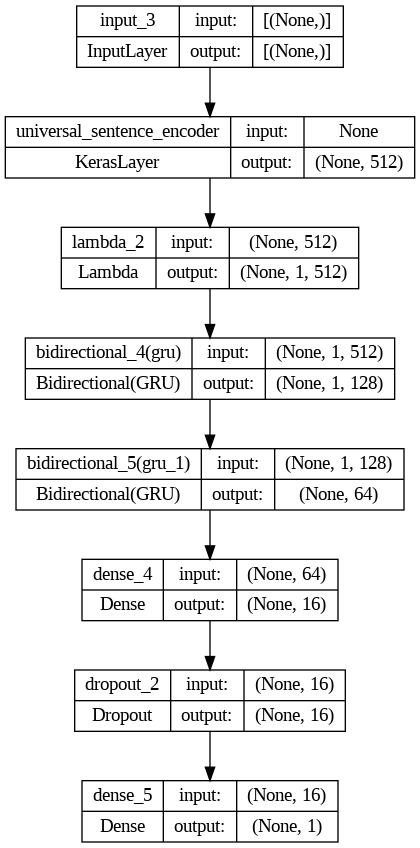

In [79]:
plot_model(model_3, show_shapes=True)

In [80]:
model_3.compile(loss = BinaryCrossentropy(),
                optimizer = Adam(),
                metrics=["accuracy"])

In [81]:
history_3 = model_3.fit(train_dataset,
                        validation_data = test_dataset,
                        class_weight = weights,
                        callbacks = create_tensorboard_callback("GRU_model"),
                        epochs = 5)

Epoch 1/5
4311/4311 [==============================] - 128s 27ms/step - loss: 0.8337 - accuracy: 0.8250 - val_loss: 0.3413 - val_accuracy: 0.8566
Epoch 2/5
4311/4311 [==============================] - 115s 27ms/step - loss: 0.6779 - accuracy: 0.8667 - val_loss: 0.3157 - val_accuracy: 0.8698
Epoch 3/5
4311/4311 [==============================] - 110s 25ms/step - loss: 0.6114 - accuracy: 0.8820 - val_loss: 0.2791 - val_accuracy: 0.8867
Epoch 4/5
4311/4311 [==============================] - 117s 27ms/step - loss: 0.5665 - accuracy: 0.8912 - val_loss: 0.2685 - val_accuracy: 0.8910
Epoch 5/5
4311/4311 [==============================] - 117s 27ms/step - loss: 0.5288 - accuracy: 0.8993 - val_loss: 0.2761 - val_accuracy: 0.8889


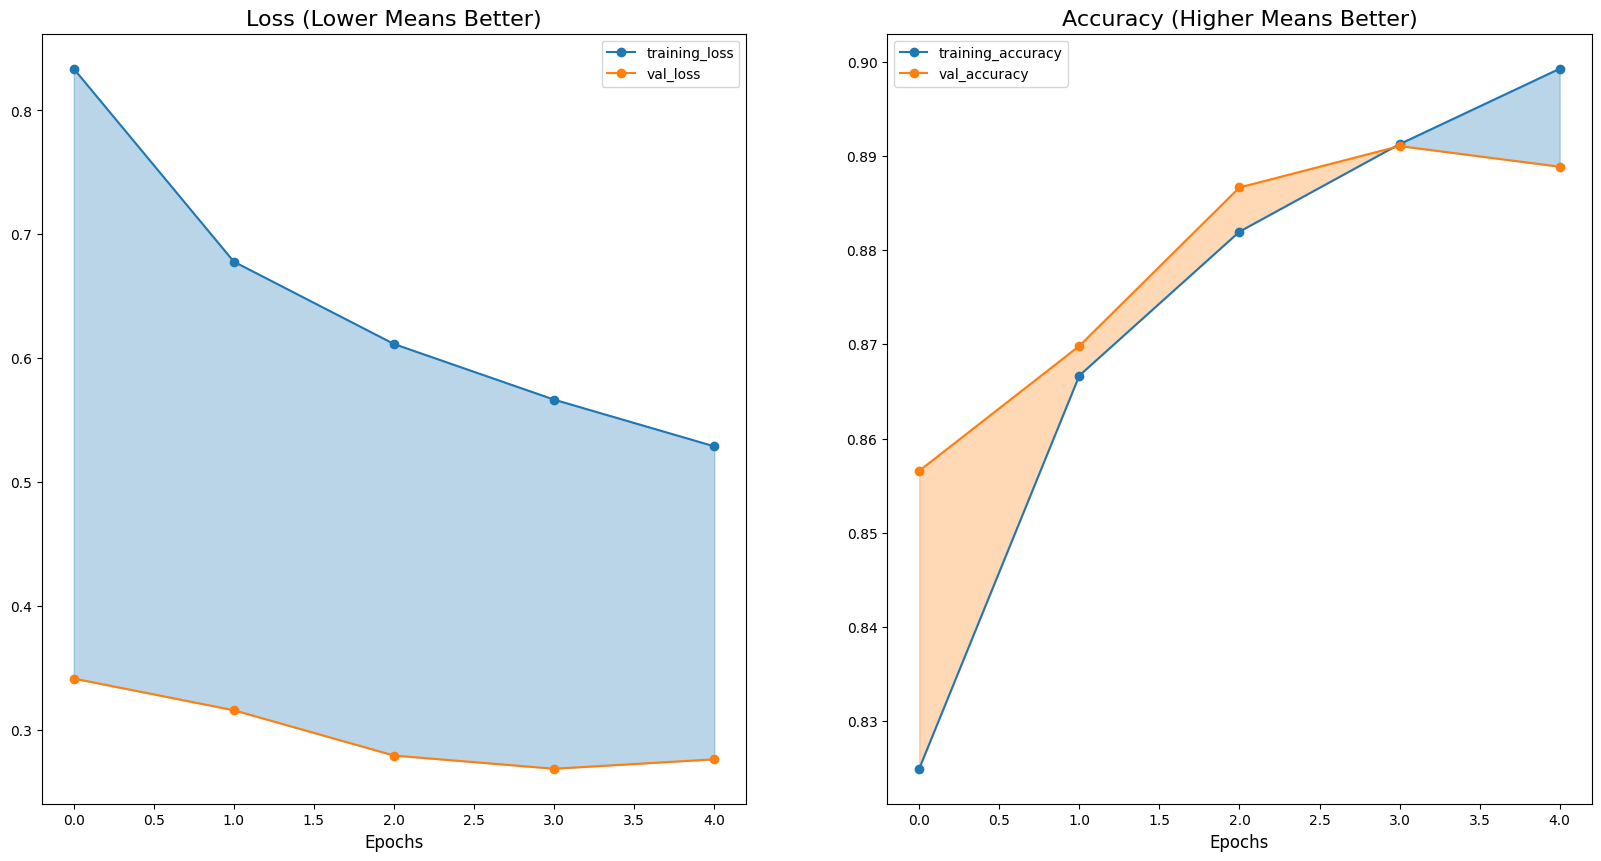

In [82]:
plot_loss_curves(history_3)

In [83]:
model_preds = model_3.predict(test_sentences, verbose=1)
model_preds

2156/2156 [==============================] - 32s 14ms/step


array([[1.4845559e-05],
       [1.0602700e-02],
       [9.0728042e-04],
       ...,
       [6.4294416e-01],
       [3.0212814e-05],
       [9.9999833e-01]], dtype=float32)

In [84]:
model_preds = np.round(model_preds)
model_preds[:5]

array([[0.],
       [0.],
       [0.],
       [1.],
       [0.]], dtype=float32)

In [85]:
true_value = np.array(y_test)
predicted_value = np.array(model_preds)

In [86]:
model_3_results = calculate_results(y_true = true_value,
                                    y_pred = predicted_value)
model_3_results

{'accuracy': 88.88550548112059,
 'precision': 0.8977743317284164,
 'recall': 0.8888550548112059,
 'f1': 0.8908636490591658}

Confusion Matrix


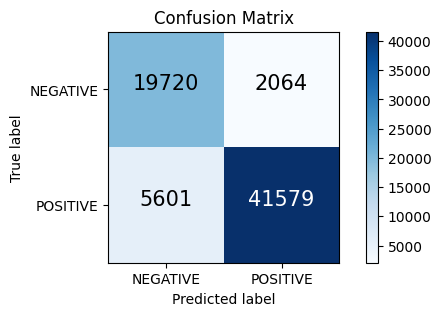

In [87]:
print("Confusion Matrix")
make_confusion_matrix(y_true = true_value,
                      y_pred = predicted_value,
                      classes = class_labels,
                      figsize = (7, 3))

In [88]:
print("Classification Report")
classification_report(true_value, predicted_value)

Classification Report


'              precision    recall  f1-score   support\n\n           0       0.78      0.91      0.84     21784\n           1       0.95      0.88      0.92     47180\n\n    accuracy                           0.89     68964\n   macro avg       0.87      0.89      0.88     68964\nweighted avg       0.90      0.89      0.89     68964\n'

ClassWise Accuracy


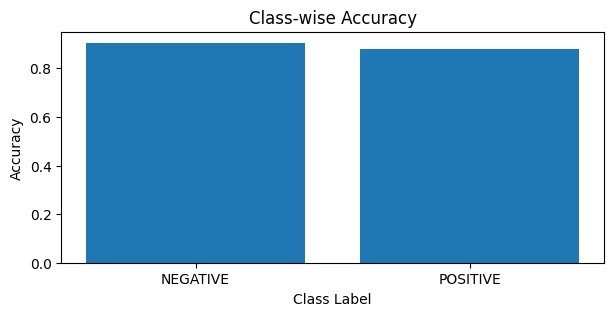

In [89]:
print("ClassWise Accuracy")
plot_class_accuracy(num_classes = 2,
                    y_true = true_value,
                    y_pred = predicted_value,
                    classes = class_labels,
                    figsize = (7, 3))

# Conv1D Model

In [90]:
input_layer = Input(shape=[], dtype=tf.string)
embeddings = embedding_layer(input_layer)
expand_layer = layers.Lambda(lambda embed: tf.expand_dims(embed, axis=1))(embeddings)
x = Conv1D(32, 3, activation='relu', padding='same')(expand_layer)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(1, activation='sigmoid')(x)
model_4 = tf.keras.Model(inputs = input_layer,
                         outputs = output_layer)

model_4.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 lambda_3 (Lambda)           (None, 1, 512)            0         
                                                                 
 conv1d (Conv1D)             (None, 1, 32)             49184     
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 32)                1056      
                                                           

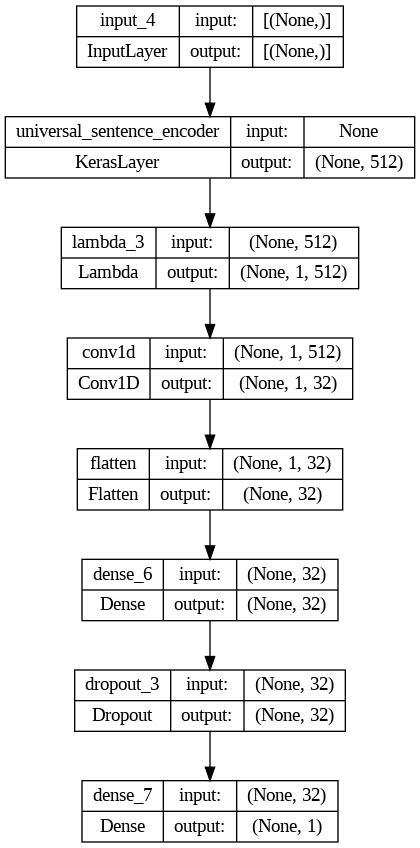

In [91]:
plot_model(model_4, show_shapes=True)

In [92]:
model_4.compile(loss = BinaryCrossentropy(),
                optimizer = Adam(),
                metrics=["accuracy"])

In [93]:
history_4 = model_4.fit(train_dataset,
                        validation_data = test_dataset,
                        class_weight = weights,
                        callbacks = create_tensorboard_callback("CNN_model"),
                        epochs = 5)

Epoch 1/5
4311/4311 [==============================] - 97s 21ms/step - loss: 0.7962 - accuracy: 0.8312 - val_loss: 0.3309 - val_accuracy: 0.8610
Epoch 2/5
4311/4311 [==============================] - 84s 19ms/step - loss: 0.6579 - accuracy: 0.8662 - val_loss: 0.3048 - val_accuracy: 0.8736
Epoch 3/5
4311/4311 [==============================] - 93s 21ms/step - loss: 0.6090 - accuracy: 0.8772 - val_loss: 0.3156 - val_accuracy: 0.8659
Epoch 4/5
4311/4311 [==============================] - 86s 20ms/step - loss: 0.5840 - accuracy: 0.8819 - val_loss: 0.2894 - val_accuracy: 0.8813
Epoch 5/5
4311/4311 [==============================] - 84s 19ms/step - loss: 0.5669 - accuracy: 0.8858 - val_loss: 0.3043 - val_accuracy: 0.8722


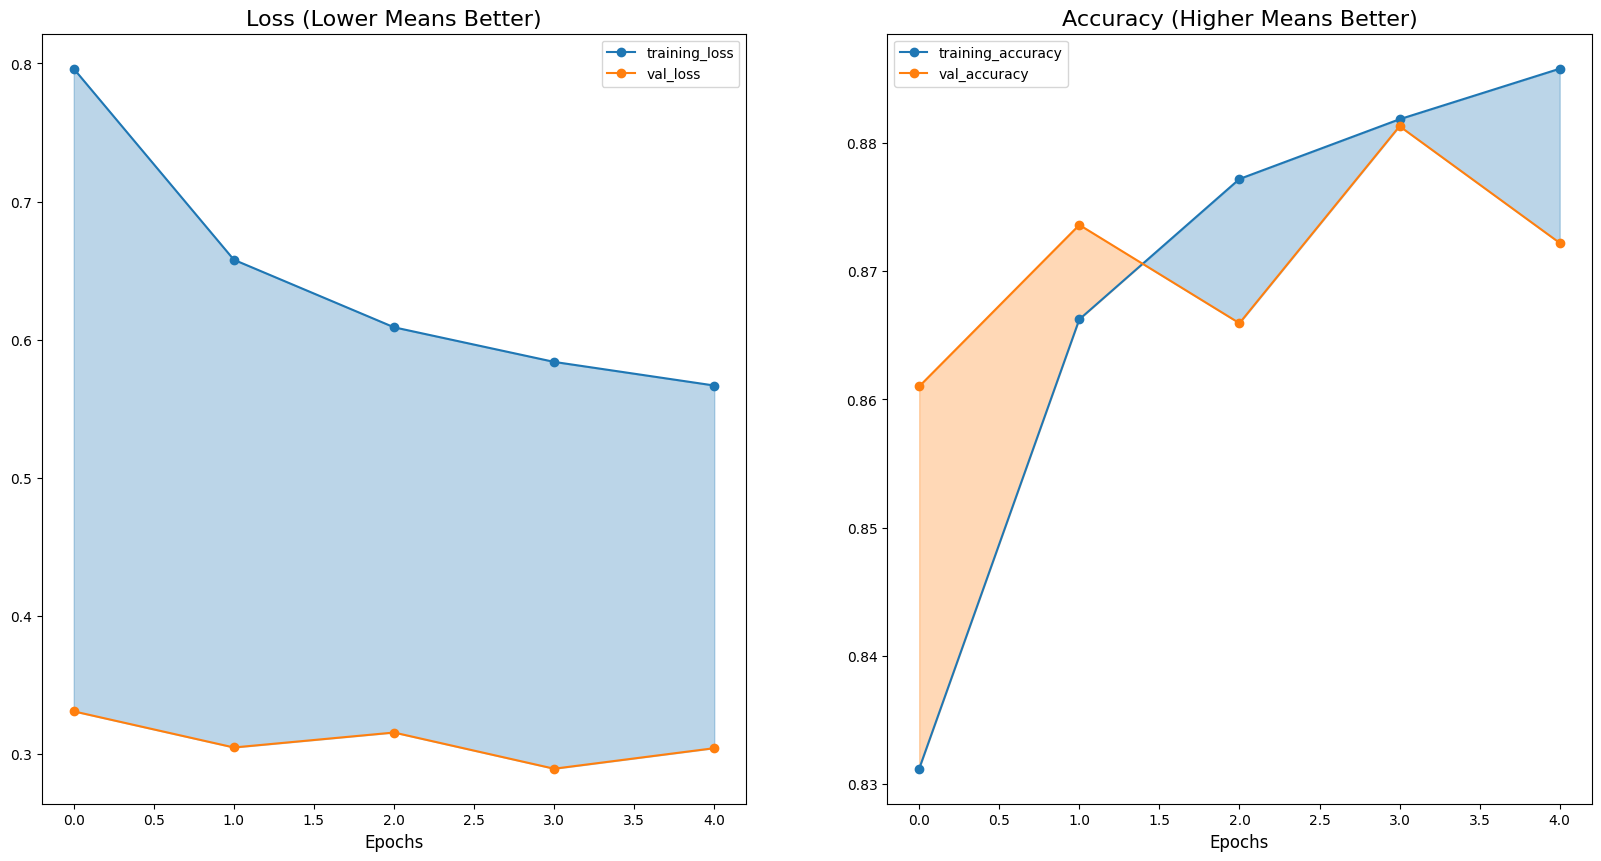

In [94]:
plot_loss_curves(history_4)

In [95]:
model_preds = model_4.predict(test_sentences, verbose=1)
model_preds

2156/2156 [==============================] - 26s 12ms/step


array([[4.6381592e-03],
       [1.5341467e-02],
       [7.4229566e-03],
       ...,
       [4.5244437e-01],
       [1.4738552e-04],
       [9.9955803e-01]], dtype=float32)

In [96]:
model_preds = np.round(model_preds)
model_preds[:5]

array([[0.],
       [0.],
       [0.],
       [1.],
       [0.]], dtype=float32)

In [97]:
true_value = np.array(y_test)
predicted_value = np.array(model_preds)

In [98]:
model_4_results = calculate_results(y_true = true_value,
                                    y_pred = predicted_value)
model_4_results

{'accuracy': 87.2208688591149,
 'precision': 0.8847699028995575,
 'recall': 0.872208688591149,
 'f1': 0.874916977981592}

Confusion Matrix


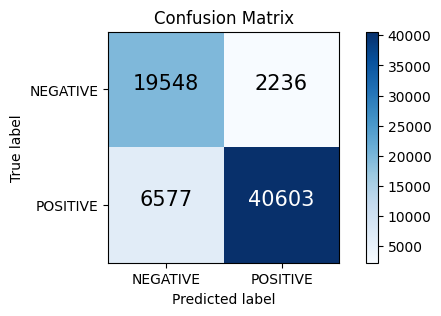

In [99]:
print("Confusion Matrix")
make_confusion_matrix(y_true = true_value,
                      y_pred = predicted_value,
                      classes = class_labels,
                      figsize = (7, 3))

In [100]:
print("Classification Report")
print(classification_report(true_value, predicted_value))

Classification Report
              precision    recall  f1-score   support

           0       0.75      0.90      0.82     21784
           1       0.95      0.86      0.90     47180

    accuracy                           0.87     68964
   macro avg       0.85      0.88      0.86     68964
weighted avg       0.88      0.87      0.87     68964



ClassWise accuracy


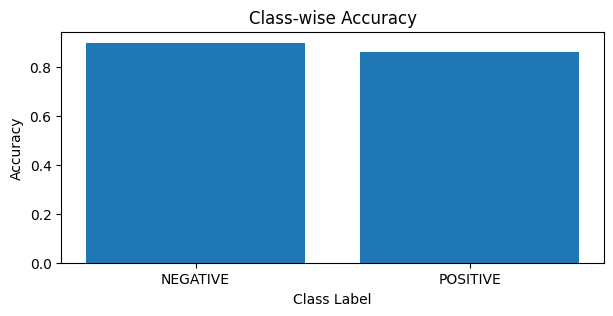

In [101]:
print("ClassWise accuracy")
plot_class_accuracy(num_classes = 2,
                    y_true = true_value,
                    y_pred = predicted_value,
                    classes = class_labels,
                    figsize = (7, 3))

# Simple LSTM-Bidirectional

In [102]:
input_layer = Input(shape=(1,), dtype=tf.string)
text_vectors = vectorize_layer(input_layer)
token_embeddings = token_embed(text_vectors)
x = Bidirectional(LSTM(64, return_sequences=True))(token_embeddings)
x = Bidirectional(LSTM(32))(x)
x = Dense(16, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(1, activation='sigmoid')(x)
model_5 = Model(inputs = input_layer,
                outputs = output_layer)

model_5.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 10)                0         
 ctorization)                                                    
                                                                 
 Embeddings (Embedding)      (None, 10, 128)           2560000   
                                                                 
 bidirectional_6 (Bidirecti  (None, 10, 128)           98816     
 onal)                                                           
                                                                 
 bidirectional_7 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                           

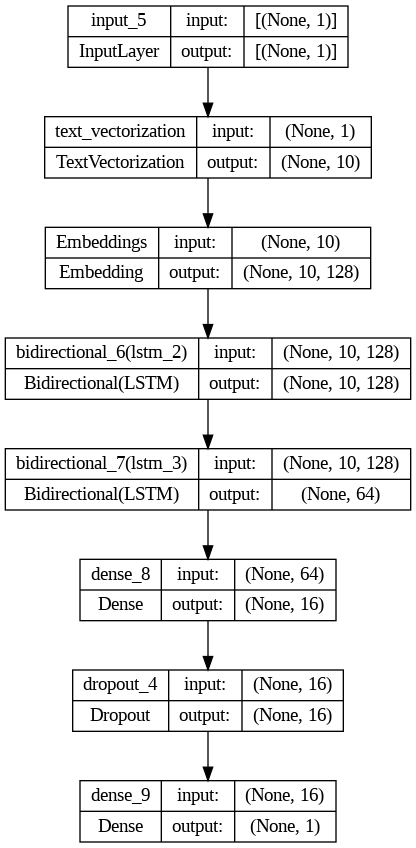

In [103]:
plot_model(model_5, show_shapes=True)

In [104]:
model_5.compile(loss = BinaryCrossentropy(),
                optimizer = Adam(),
                metrics = ['accuracy'])

In [105]:
history_5 = model_5.fit(train_dataset,
                        validation_data = test_dataset,
                        callbacks = create_tensorboard_callback("Simple_LSTM_model"),
                        class_weight = weights,
                        epochs = 5)

Epoch 1/5
4311/4311 [==============================] - 103s 21ms/step - loss: 0.1602 - accuracy: 0.9718 - val_loss: 0.0272 - val_accuracy: 0.9890
Epoch 2/5
4311/4311 [==============================] - 72s 17ms/step - loss: 0.0509 - accuracy: 0.9902 - val_loss: 0.0239 - val_accuracy: 0.9909
Epoch 3/5
4311/4311 [==============================] - 79s 18ms/step - loss: 0.0315 - accuracy: 0.9940 - val_loss: 0.0278 - val_accuracy: 0.9921
Epoch 4/5
4311/4311 [==============================] - 73s 17ms/step - loss: 0.0207 - accuracy: 0.9960 - val_loss: 0.0294 - val_accuracy: 0.9915
Epoch 5/5
4311/4311 [==============================] - 75s 17ms/step - loss: 0.0142 - accuracy: 0.9971 - val_loss: 0.0450 - val_accuracy: 0.9914


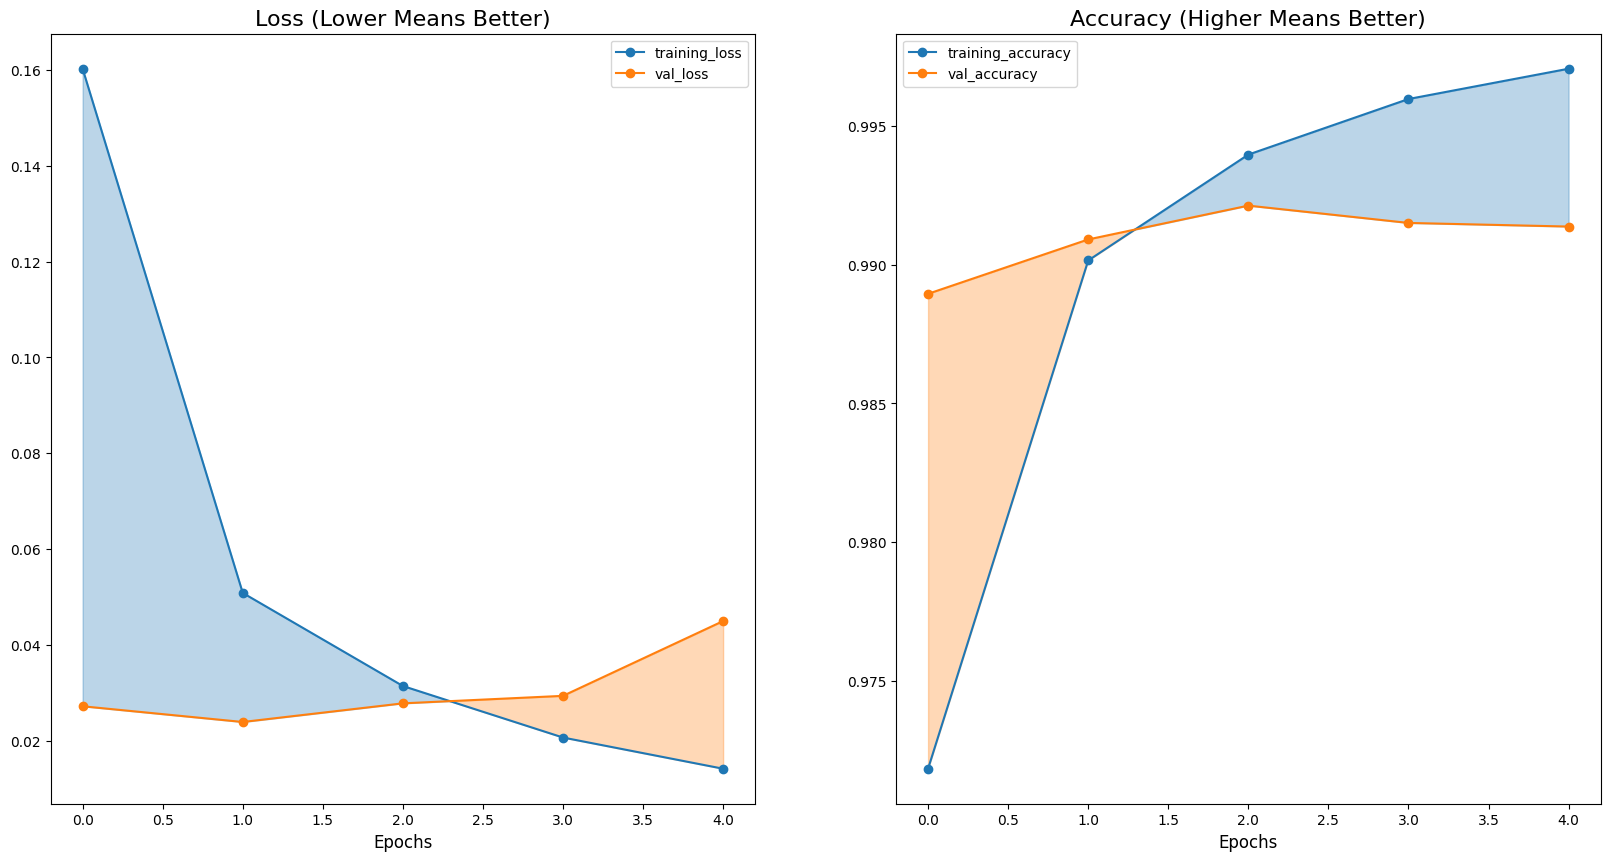

In [106]:
plot_loss_curves(history_5)

In [130]:
true_labels = []
predicted_labels = []
text = []

for batch_text, batch_labels in test_dataset:
    batch_predictions = model_5.predict(batch_text)
    batch_predicted_labels = np.round(batch_predictions)
    text.extend(batch_text)
    true_labels.extend(batch_labels)
    predicted_labels.extend(batch_predicted_labels)

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

2/2 [==============================] - 0s 14ms/step


In [131]:
model_5_results = calculate_results(y_true = true_labels,
                                    y_pred = predicted_labels)
model_5_results

{'accuracy': 99.13723101908242,
 'precision': 0.9914183373948839,
 'recall': 0.9913723101908242,
 'f1': 0.9913838505312158}

Confusion Matrix


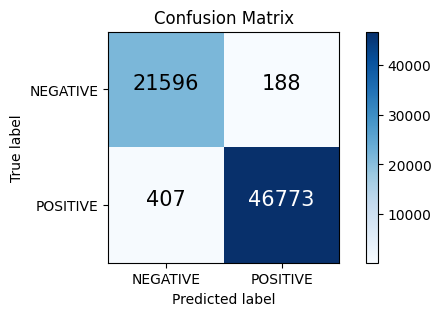

In [132]:
print("Confusion Matrix")
make_confusion_matrix(y_true = true_labels,
                      y_pred = predicted_labels,
                      classes = class_labels,
                      figsize = (7, 3))

In [133]:
print("Classification Report")
print(classification_report(true_labels, predicted_labels))

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     21784
           1       1.00      0.99      0.99     47180

    accuracy                           0.99     68964
   macro avg       0.99      0.99      0.99     68964
weighted avg       0.99      0.99      0.99     68964



ClassWise Accuracy


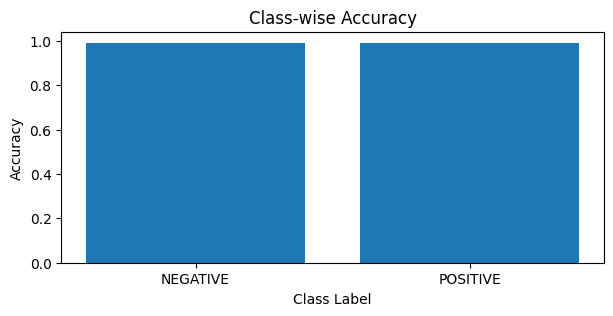

In [134]:
print("ClassWise Accuracy")
plot_class_accuracy(num_classes = 2,
                    y_true = true_labels,
                    y_pred = predicted_labels,
                    classes = class_labels,
                    figsize = (7, 3))

In [135]:
model_5.save("News_Sentiment_Analysis_model")

# Wrong Predictions analysis

In [136]:
model_pred_prob = model_5.predict(df['text'].values, verbose=1)

10776/10776 [==============================] - 90s 8ms/step


In [137]:
model_preds = tf.argmax(model_pred_prob, axis=1)
model_preds[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 0, 0, 0, 0])>

In [138]:
model_preds = list(np.array(model_preds))

In [139]:
pred_classes = [class_labels[int(pred)] for pred in model_preds]

In [140]:
df['Prediction'] = pred_classes
df['Preds_prob'] = np.round(model_pred_prob)
df['Correct'] = df['Prediction'] == df['label']
df.head(5)

,text,label,Prediction,Preds_prob,Correct
0,act fire witnesses must be aware of defamation,0,NEGATIVE,0.0,False
1,air nz staff in aust strike for pay rise,0,NEGATIVE,0.0,False
2,air nz strike to affect australian travellers,0,NEGATIVE,0.0,False
3,ambitious olsson wins triple jump,1,NEGATIVE,1.0,False
4,antic delighted with record breaking barca,1,NEGATIVE,1.0,False


In [141]:
top_10_wrong = df[df['Correct'] == False].sort_values("Preds_prob", ascending=False)[:10]

In [142]:
top_10_wrong

,text,label,Prediction,Preds_prob,Correct
173467,union files documents for high court budget fight,1,NEGATIVE,1.0,False
289168,australia wins bronze in team eventing,1,NEGATIVE,1.0,False
170019,being around heavy drinkers may be bad for health,1,NEGATIVE,1.0,False
289156,thailands major players accept referendum result,1,NEGATIVE,1.0,False
289155,temperatures rising but frost risk remains high,1,NEGATIVE,1.0,False
170023,call for total ban on phones while driving,1,NEGATIVE,1.0,False
170024,caps too strong for logan,1,NEGATIVE,1.0,False
170025,coleraine reflects on black saturday achievements,1,NEGATIVE,1.0,False
289153,students sent to the amazon to study similarit...,1,NEGATIVE,1.0,False
170027,creswick woman distraught after third flood,1,NEGATIVE,1.0,False


# Model at inference

In [143]:
test_data = tf.data.Dataset.from_tensor_slices([["this movie looks very interesting, i love the fact that the actors do a great job in showing how people lived in the 18th century, which wasn't very good at all. But atleast this movie recreates this scenes! "],
                                              ["very good start, but movie started becoming interesting at some point and fortunately at some point it started becoming much more fun, though there was too much background noise, so in all i liked this movie "],])


In [144]:
model_preds = model_5.predict(test_data)

2/2 [==============================] - 0s 11ms/step


In [145]:
model_preds = tf.argmax(model_preds, axis=1)

In [146]:
model_preds = list(np.array(model_preds))

In [147]:
[class_labels[int(pred)] for pred in model_preds]

['NEGATIVE', 'NEGATIVE']

# Comparing model performance

In [148]:
models_result = pd.DataFrame({
    'RNN-Bidirectional': model_1_results,
    'LSTM-Bidirectional': model_2_results,
    'GRU-Bidirectional': model_3_results,
    'Conv-1D-Model': model_4_results,
    'Simple-LSTM-Model': model_5_results
})

models_result = models_result.transpose()
models_result['accuracy'] = models_result['accuracy'] / 100
models_result

,accuracy,precision,recall,f1
RNN-Bidirectional,0.868816,0.873894,0.868816,0.870408
LSTM-Bidirectional,0.888754,0.898370,0.888754,0.890849
GRU-Bidirectional,0.888855,0.897774,0.888855,0.890864
Conv-1D-Model,0.872209,0.884770,0.872209,0.874917
Simple-LSTM-Model,0.991372,0.991418,0.991372,0.991384


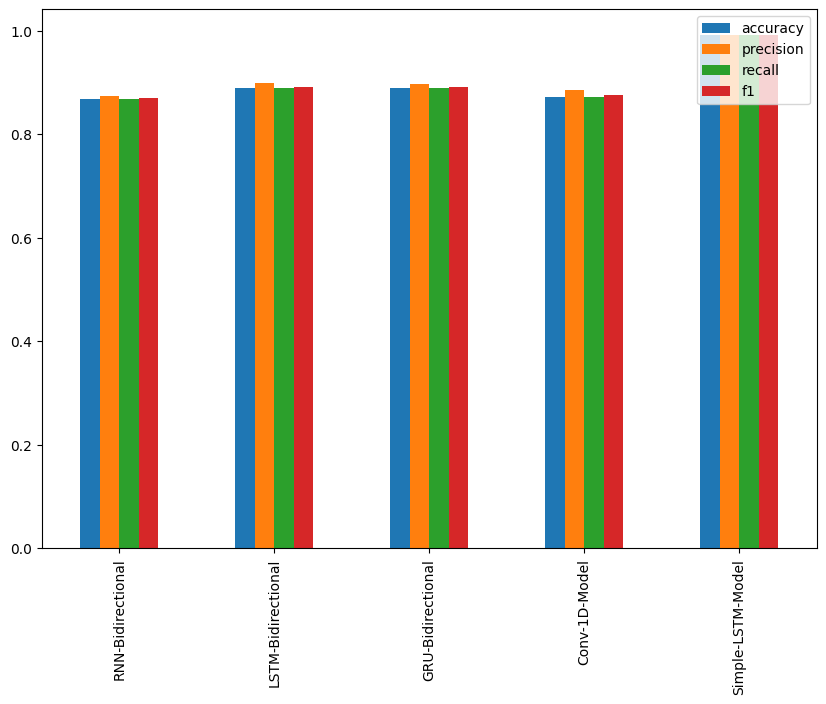

In [149]:
models_result.plot(kind='bar', figsize=(10, 7));

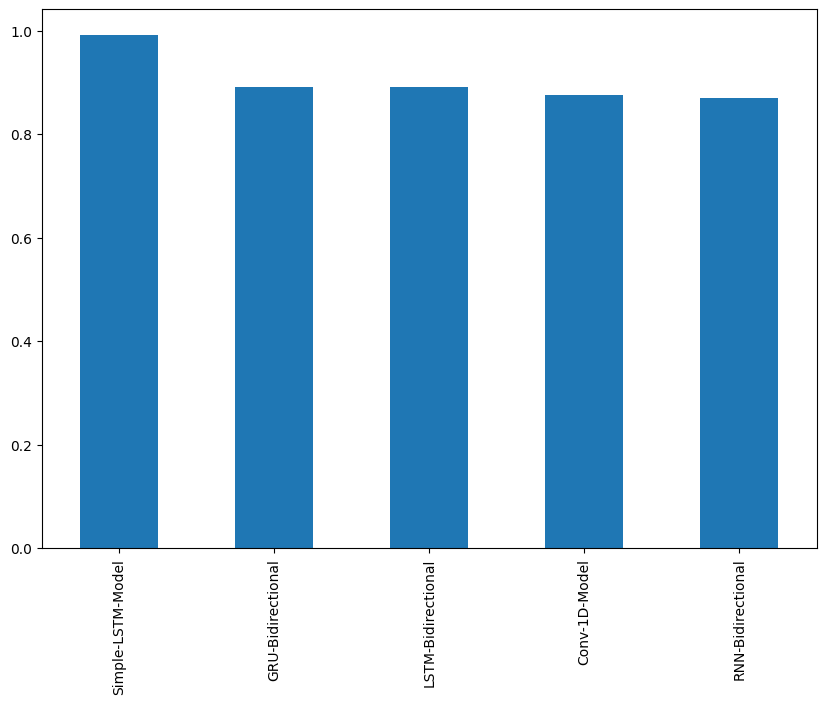

In [150]:
models_result.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

# Saving Model

In [ ]:
model_5.save("News_Sentiment_Analysis_model")

In [151]:
%cp -av /content/News_Sentiment_Analysis_model /content/drive/MyDrive/News_Sentiment_Analysis_model

'/content/News_Sentiment_Analysis_model' -> '/content/drive/MyDrive/News_Sentiment_Analysis_model'
'/content/News_Sentiment_Analysis_model/variables' -> '/content/drive/MyDrive/News_Sentiment_Analysis_model/variables'
'/content/News_Sentiment_Analysis_model/variables/variables.index' -> '/content/drive/MyDrive/News_Sentiment_Analysis_model/variables/variables.index'
'/content/News_Sentiment_Analysis_model/variables/variables.data-00000-of-00001' -> '/content/drive/MyDrive/News_Sentiment_Analysis_model/variables/variables.data-00000-of-00001'
'/content/News_Sentiment_Analysis_model/assets' -> '/content/drive/MyDrive/News_Sentiment_Analysis_model/assets'
'/content/News_Sentiment_Analysis_model/fingerprint.pb' -> '/content/drive/MyDrive/News_Sentiment_Analysis_model/fingerprint.pb'
'/content/News_Sentiment_Analysis_model/saved_model.pb' -> '/content/drive/MyDrive/News_Sentiment_Analysis_model/saved_model.pb'
'/content/News_Sentiment_Analysis_model/keras_metadata.pb' -> '/content/drive/MyD

In [152]:
%cp -av /content/logs /content/drive/MyDrive/News_Sentiment_Analysis_model/

'/content/logs' -> '/content/drive/MyDrive/News_Sentiment_Analysis_model/logs'
'/content/logs/RNN_model_20230922-183224' -> '/content/drive/MyDrive/News_Sentiment_Analysis_model/logs/RNN_model_20230922-183224'
'/content/logs/RNN_model_20230922-183224/train' -> '/content/drive/MyDrive/News_Sentiment_Analysis_model/logs/RNN_model_20230922-183224/train'
'/content/logs/RNN_model_20230922-183224/train/events.out.tfevents.1695407544.b4e845e28639.264.0.v2' -> '/content/drive/MyDrive/News_Sentiment_Analysis_model/logs/RNN_model_20230922-183224/train/events.out.tfevents.1695407544.b4e845e28639.264.0.v2'
'/content/logs/RNN_model_20230922-183224/validation' -> '/content/drive/MyDrive/News_Sentiment_Analysis_model/logs/RNN_model_20230922-183224/validation'
'/content/logs/RNN_model_20230922-183224/validation/events.out.tfevents.1695407673.b4e845e28639.264.1.v2' -> '/content/drive/MyDrive/News_Sentiment_Analysis_model/logs/RNN_model_20230922-183224/validation/events.out.tfevents.1695407673.b4e845e28

# Tensorboard

In [ ]:
%cp -av /content/drive/MyDrive/News_Sentiment_Analysis/logs /content/logs

'/content/drive/MyDrive/News_Sentiment_Analysis/logs' -> '/content/logs'
'/content/drive/MyDrive/News_Sentiment_Analysis/logs/RNN_model_20230907-194318' -> '/content/logs/RNN_model_20230907-194318'
'/content/drive/MyDrive/News_Sentiment_Analysis/logs/RNN_model_20230907-194318/train' -> '/content/logs/RNN_model_20230907-194318/train'
'/content/drive/MyDrive/News_Sentiment_Analysis/logs/RNN_model_20230907-194318/train/events.out.tfevents.1694115798.9d01ccbceba3.497.0.v2' -> '/content/logs/RNN_model_20230907-194318/train/events.out.tfevents.1694115798.9d01ccbceba3.497.0.v2'
'/content/drive/MyDrive/News_Sentiment_Analysis/logs/RNN_model_20230907-194318/validation' -> '/content/logs/RNN_model_20230907-194318/validation'
'/content/drive/MyDrive/News_Sentiment_Analysis/logs/RNN_model_20230907-194318/validation/events.out.tfevents.1694115809.9d01ccbceba3.497.1.v2' -> '/content/logs/RNN_model_20230907-194318/validation/events.out.tfevents.1694115809.9d01ccbceba3.497.1.v2'
'/content/drive/MyDriv

In [ ]:
!kill 21042

/bin/bash: line 1: kill: (21042) - No such process


In [153]:
%load_ext tensorboard
%tensorboard --logdir /content/logs

<IPython.core.display.Javascript object>

# Hugging Face

In [154]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [155]:
import tensorflow as tf

In [156]:
! pip install huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 5.5 MB/s eta 0:00:00


In [157]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
path = "/content/drive/MyDrive/News_Sentiment_Analysis/model"
model = tf.keras.models.load_model(path)

In [159]:
from huggingface_hub.keras_mixin import push_to_hub_keras
push_to_hub_keras(model = model_5, repo_id = "DriveMyScream/News_Sentiment_Analysis_model")

fingerprint.pb:   0%|          | 0.00/55.0 [00:00<?, ?B/s]

saved_model.pb:   0%|          | 0.00/4.38M [00:00<?, ?B/s]

keras_metadata.pb:   0%|          | 0.00/31.8k [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

variables.data-00000-of-00001:   0%|          | 0.00/10.8M [00:00<?, ?B/s]

'https://huggingface.co/DriveMyScream/News_Sentiment_Analysis_model/tree/main/'

In [160]:
from huggingface_hub import from_pretrained_keras
loaded_model = from_pretrained_keras("DriveMyScream/News_Sentiment_Analysis_model")

config.json not found in HuggingFace Hub.


Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

In [161]:
import numpy as np

In [162]:
test_data = tf.data.Dataset.from_tensor_slices([["House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It"],
                                              ["American Drivers Regain Appetite for Gas Guzzlers - The New York Times"]])
class_labels = ['Negative', 'Positive']
model_pred_probs = loaded_model.predict(test_data)
model_preds = np.round(model_pred_probs)
prediction = [class_labels[int(pred)] for pred in model_preds]
print("Predictions:", prediction)

2/2 [==============================] - 4s 12ms/step
Predictions: ['Negative', 'Negative']


# Tensorflow Lite

In [163]:
import tensorflow as tf

# path = "/content/drive/MyDrive/News_Sentiment_Analysis/model"
# model = tf.keras.models.load_model(path)

converter = tf.lite.TFLiteConverter.from_keras_model(model_5)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

tflite_output_path = "News_Sentiment_Analysis.tflite"
with open(tflite_output_path, "wb") as f:
    f.write(tflite_model)

In [165]:
model_path = "/content/News_Sentiment_Analysis.tflite"
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

test_data = ["American Drivers Regain Appetite for Gas Guzzlers - The New York Times"]
class_labels = ['Negative', 'Positive']

def preprocess_text(text):
    text = text.lower()
    tokens = text.split()
    return " ".join(tokens)

def predict_tflite(text):
    input_data = np.array([[preprocess_text(text)]], dtype=str)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    predicted_class = int(np.round(output_data))
    return class_labels[predicted_class]

tflite_predictions = [predict_tflite(text) for text in test_data]

for text, prediction in zip(test_data, tflite_predictions):
    print(f"Text: {text}")
    print(f"Prediction: {prediction}")

Text: American Drivers Regain Appetite for Gas Guzzlers - The New York Times
Prediction: Negative
